In [1]:
%matplotlib inline
import numpy as np
#%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation, LinearTriInterpolator
from scipy.interpolate import splrep, splev, splprep, interp1d
from scipy.optimize import curve_fit
import matplotlib.font_manager as fm
import matplotlib.ticker as mtick
from decimal import Decimal
import scipy
from scipy import special
from scipy.integrate import trapz, simps
import I_n_P as P
from importlib import reload
plt.style.use('ggplot')
path = 'C:\\WINDOWS\\Fonts\\BOOKOS.TTF'
prop = fm.FontProperties(fname=path)
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'heavy'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}',
          r'\usepackage{xfrac}']

In [2]:
reload(P)

<module 'I_n_P' from 'C:\\Users\\giann\\OneDrive\\Desktop\\Python_scrpts\\I_n_P.py'>

Reading values and calculating relevant geometric quantities.

In [3]:
'''Reading in all values'''
angle_B,Bp,B = P.magnetic_read()
R_nodes = np.load('C:\\Users\\giann\\OneDrive\\Desktop\\Python_scrpts\\ti262\\ti262_R_sep.npy')
Z_nodes = np.load('C:\\Users\\giann\\OneDrive\\Desktop\\Python_scrpts\\ti262\\ti262_Z_sep.npy')
pot = np.load('C:\\Users\\giann\\OneDrive\\Desktop\\Python_scrpts\\ti262\\ti262_phi.npy')
n = np.load('C:\\Users\\giann\\OneDrive\\Desktop\\Python_scrpts\\ti262\\ti262_den.npy')
i_T_perp = np.load('C:\\Users\\giann\\OneDrive\\Desktop\\Python_scrpts\\ti262\\ti262_i_T_perp.npy')
i_E_para = np.load('C:\\Users\\giann\\OneDrive\\Desktop\\Python_scrpts\\ti262\\ti262_i_E_para.npy')
e_T_perp = np.load('C:\\Users\\giann\\OneDrive\\Desktop\\Python_scrpts\\ti262\\ti262_e_T_perp.npy')
e_E_para = np.load('C:\\Users\\giann\\OneDrive\\Desktop\\Python_scrpts\\ti262\\ti262_e_E_para.npy')
angle_ddr,R_s,Z_s = P.R_Z_read()

In [4]:
'''Performing theta interpolations of values.'''
Bp = P.angle_interp(angle_B,Bp,1) #We shouldnt smooth geometric and magnetic field quantities.
B = P.angle_interp(angle_B,B,1)
R_s = P.angle_interp(angle_ddr,R_s,1)
Z_s = P.angle_interp(angle_ddr,Z_s,1)
angle = [x for x in range(0,360,1)]

In [5]:
'''Calculating some geometric quantities.'''
r_s,R_maj_s = P.major_R(R_s,Z_s) #minor and major radius.
J_inv = P.inv_Jac(Bp,r_s,angle) #inverse Jacobian.
Bzeta = np.sqrt(B**2 - Bp**2) #zeta comp of B.
B_factor = P.B_factor(Bzeta,B)
F = P.F_function(R_maj_s, Bzeta) #B = F \nabla \zeta + \nabla \Psi \times \nabla \zeta.
R_Bp_B2 = np.power(B,2) * R_maj_s * Bp #geometric factor to divide in order to make correct flux, cf. notes.
geometric_factor = np.power(R_maj_s,2)*J_inv/F #geometric factor for remaping. 

In [6]:
'''Creates a list of angles corresponding to each of the nodes.'''
node_angles = P.norm_atan(Z_nodes,R_nodes-0.68) #Important to subtract the major radius.

Temperatures are recorded in half planes. Therefore, we have to remap them. For the remaping we use the fact that the system is axisymmetric therefore, $\frac{d\bar{T}}{d\zeta} = 0$. As for the perturbations of $T$, we assume that they are constant along the field lines therefore, $B\cdot \nabla T \approx 0.$

In [7]:
'''Calculating temperatures.'''
T_i = 2/3.*(i_T_perp + i_E_para)
T_e = 2/3.*(e_T_perp + e_E_para)
'''Breaking up in mean and perturbed parts.'''
Ti_tor = T_i.mean(axis=1)
Ti_avg = Ti_tor.mean(axis=1)
dTi = T_i - Ti_avg[:,np.newaxis,np.newaxis]
Te_tor = T_e.mean(axis=1)
Te_avg = Te_tor.mean(axis=1)
dTe = T_e - Te_avg[:,np.newaxis,np.newaxis]
'''Creates matrix of interpolations for perturbed parts.'''
dTi_inter = np.asarray([])
dTe_inter = np.asarray([])
for time in range(0,dTi.shape[2]):
    for plane in range(0,dTi.shape[1]):
        dTi_inter = np.append(dTi_inter,P.angle_interp(node_angles,dTi[:,plane,time],30,True))
        dTe_inter = np.append(dTe_inter,P.angle_interp(node_angles,dTe[:,plane,time],30,True))

dTe_inter  = np.reshape(dTe_inter,(dTe.shape[2],dTe.shape[1],360))        
dTi_inter  = np.reshape(dTi_inter,(dTi.shape[2],dTi.shape[1],360))

In [8]:
'''Does the remapping of the temperature perturbation to the correct plane.'''
remap_i = np.asarray([])
remap_e = np.asarray([])
for time in range(0,dTi.shape[2]):
    for plane in range(0,dTi.shape[1]):
        remap_i = np.append(remap_i,P.map_half_plane(dTi_inter[time,plane,:],dTi_inter[time,(plane+1)%dTi.shape[1],:],geometric_factor,node_angles))
        remap_e = np.append(remap_e,P.map_half_plane(dTe_inter[time,plane,:],dTe_inter[time,(plane+1)%dTe.shape[1],:],geometric_factor,node_angles))

dTi_inter = np.reshape(remap_i,(dTi.shape[2],dTi.shape[1],360))
dTe_inter = np.reshape(remap_e,(dTe.shape[2],dTe.shape[1],360))

In [9]:
'''Does the interpolation of the average temperatures.'''
Ti_avg = P.angle_interp(node_angles,Ti_avg[:],30,True)
Te_avg = P.angle_interp(node_angles,Te_avg[:],30,True)

In [10]:
'''Joins mean and perturbed parts to make total temperature.'''
Ti = Ti_avg+dTi_inter
Te = Te_avg+dTe_inter

In [11]:
'''Creates matrix of interpolations for density and potential.'''
pot_inter = np.asarray([])
n_inter = np.asarray([])
for time in range(0,pot.shape[2]):
    for plane in range(0,pot.shape[1]):
        pot_inter = np.append(pot_inter,P.angle_interp(node_angles,pot[:,plane,time],30,True))
        n_inter = np.append(n_inter,P.angle_interp(node_angles,n[:,plane,time],30,True))

pot_inter  = np.reshape(pot_inter,(pot.shape[2],pot.shape[1],360))
n_inter  = np.reshape(n_inter,(pot.shape[2],pot.shape[1],360))

In [12]:
'''Calculates the pressure.'''
Pi = np.multiply(n_inter, Ti)
Pe = np.multiply(n_inter, Te)

# Equilibrium Heat Flux.

In [13]:
'''Equilibrium Heat Flux.'''
pot_inter_tor = pot_inter.mean(axis=1)
pot_avg = pot_inter_tor.mean(axis=0)
Pi_tor = Pi.mean(axis=1)
Pi_avg = Pi_tor.mean(axis=0)
Pe_tor = Pe.mean(axis=1)
Pe_avg = Pe_tor.mean(axis=0)
dphidth_inter = P.ddtheta_even(angle, P.smooth(pot_avg,30)) #theta derivative on even grid.
eq_gamma_i = - (Pi_avg*F*J_inv*dphidth_inter)/(R_Bp_B2) #equilibrium exb heat flux.
eq_gamma_e = - (Pe_avg*F*J_inv*dphidth_inter)/(R_Bp_B2) #equilibrium exb heat flux.

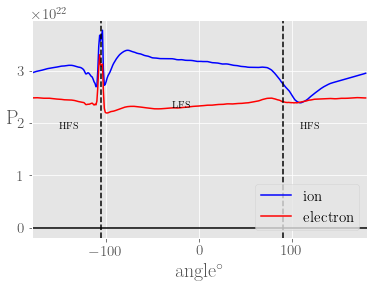

In [14]:
plt.plot([x for x in range(-180,180)], np.roll(Pi_avg,180),'b-',label='ion')
plt.plot([x for x in range(-180,180)], np.roll(Pe_avg,180),'r-',label='electron')
plt.xlabel(r'angle$^{\circ}$')
h = plt.ylabel('P')
h.set_rotation(0)
plt.axvline(x=-106,color='k',linestyle='--')
plt.axvline(x=90,color='k',linestyle='--')
plt.axhline(y=0,color='k',linestyle='-')
plt.annotate('LFS', xy=(0.3,0.5),xytext=(0.42, 0.6),textcoords='axes fraction')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.8, 0.5),textcoords='axes fraction')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.08, 0.5),textcoords='axes fraction')
plt.legend(loc=4)
plt.xlim(-180,180)
plt.show()

C:\Users\giann\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


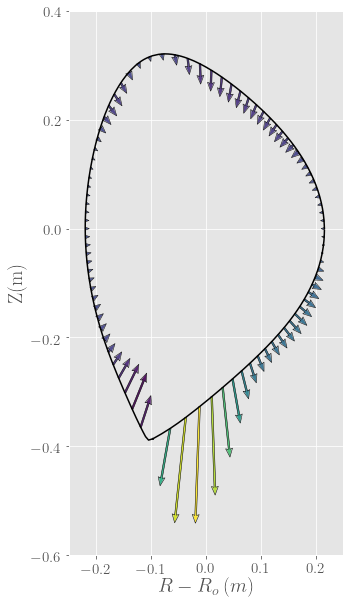

In [15]:
s_eq_gamma_i = P.smooth(eq_gamma_i,10)
'''Equilibrium ion ExB Flux.'''
new_an = np.arctan2(Z_s,R_s)
Eqx,Eqy = s_eq_gamma_i*np.cos(new_an), s_eq_gamma_i*np.sin(new_an)
plt.figure(figsize=(10,10))
plt.quiver(R_s[::4], Z_s[::4], Eqx[::4], Eqy[::4], s_eq_gamma_i[::4], alpha=.9)
plt.quiver(R_s[::4], Z_s[::4], Eqx[::4], Eqy[::4], edgecolor='k', facecolor='None', linewidth=.5, headwidth = 4)
plt.plot(R_s,Z_s,'k-')
plt.xlabel(r'$R-R_o \,(m)$')
plt.ylabel('Z(m)')
plt.xlim(-0.25,0.25)
plt.ylim(-0.6,0.4)
plt.axes().set_aspect(0.99)
plt.show()

C:\Users\giann\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


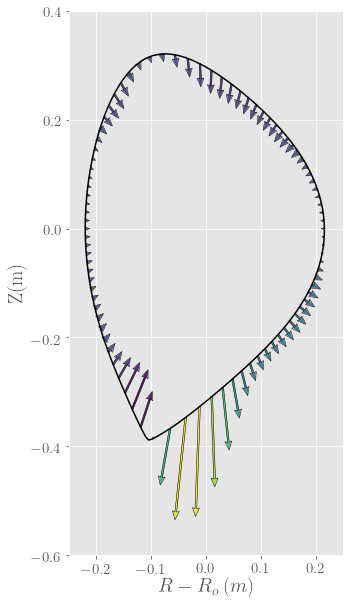

In [16]:
s_eq_gamma_e = P.smooth(eq_gamma_e,10)
'''Equilibrium electron ExB Flux.'''
new_an = np.arctan2(Z_s,R_s)
Eqx,Eqy = s_eq_gamma_e*np.cos(new_an), s_eq_gamma_e*np.sin(new_an)
plt.figure(figsize=(10,10))
plt.quiver(R_s[::4], Z_s[::4], Eqx[::4], Eqy[::4], s_eq_gamma_e[::4], alpha=.9)
plt.quiver(R_s[::4], Z_s[::4], Eqx[::4], Eqy[::4], edgecolor='k', facecolor='None', linewidth=.5, headwidth = 4)
plt.plot(R_s,Z_s,'k-')
plt.xlabel(r'$R-R_o \,(m)$')
plt.ylabel('Z(m)')
plt.xlim(-0.25,0.25)
plt.ylim(-0.6,0.4)
plt.axes().set_aspect(0.99)
plt.show()

# Turbulent Heat Flux.

Calculation of turbulent $E\times B$ velocity.

In [17]:
'''Creates average quantities on nodes.'''
pot_tor = pot.mean(axis=1)
pot_avg = pot_tor.mean(axis=1)
'''Creates perturbations.'''
dpot = pot - pot_avg[:,np.newaxis,np.newaxis]

In [18]:
'''Creates matrix of interpolations for turbulent potential.'''
dpot_inter = np.asarray([])
for time in range(0,dpot.shape[2]):
    for plane in range(0,dpot.shape[1]):
        dpot_inter = np.append(dpot_inter,P.angle_interp(node_angles,dpot[:,plane,time],10,False))

dpot_inter  = np.reshape(dpot_inter,(dpot.shape[2],dpot.shape[1],360))

In [19]:
'''Creates matrix of phi derivatives.'''
dpotdth = np.asarray([])
for time in range(0,dpot.shape[2]):
    for plane in range(0,dpot.shape[1]):
        dpotdth = np.append(dpotdth,P.ddtheta_even(node_angles,dpot_inter[time,plane,:]))
        
dpotdth  = np.reshape(dpotdth,(dpot.shape[2],dpot.shape[1],360))

In [20]:
'''Creates matrix of fluctuating ExB velocities.'''
dv = np.asarray([])
for time in range(0,dpot.shape[2]):
    for plane in range(0,dpot.shape[1]):
        dv = np.append(dv,-(F*J_inv*B_factor*dpotdth[time, plane, :])/(R_Bp_B2))
dv = np.reshape(dv,(dpot.shape[2],dpot.shape[1],360))        

 Calculating and Plotting turbulent heat fluxes.

In [21]:
'''Calculates perturbations.'''
dPi_inter = Pi-Pi_avg[np.newaxis,np.newaxis,:]
dPe_inter = Pe-Pe_avg[np.newaxis,np.newaxis,:]

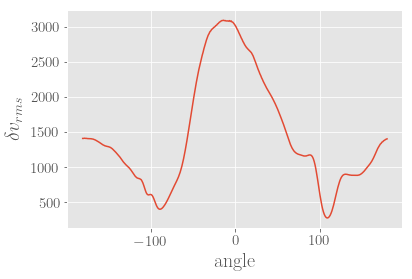

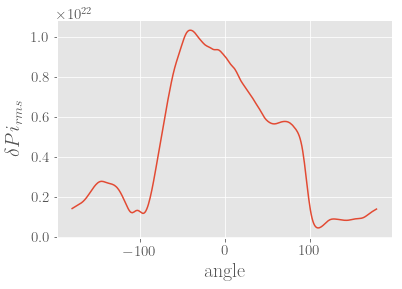

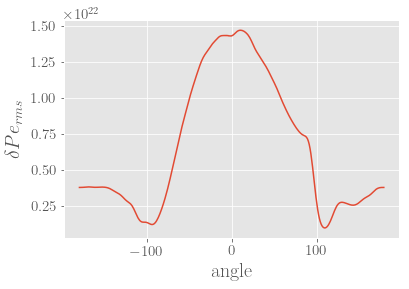

In [22]:
'''Creates matrices of perturbation strengths'''
'''Velocity'''
dv_rms = np.asarray([])
for time in range(0,dpot.shape[2]):
    for plane in range(0,dpot.shape[1]):
        dv_rms = np.append(dv_rms, np.power(dv[time, plane, :],2))

dv_rms = np.reshape(dv_rms,(dpot.shape[2],dpot.shape[1],360))
dv_rms = np.mean(dv_rms, axis=0)
dv_rms = np.mean(dv_rms,axis=0)
dv_rms = np.sqrt(dv_rms)

plt.plot([x for x in range(-180,180)], np.roll(P.smooth(dv_rms[0:360],10),180))
plt.xlabel("angle")
plt.ylabel(r"$\delta v_{rms}$")
plt.show()

'''ion pressure'''
dPi_rms = np.asarray([])
for time in range(0,dpot.shape[2]):
    for plane in range(0,dpot.shape[1]):
        dPi_rms = np.append(dPi_rms, np.power(dPi_inter[time, plane, :],2))

dPi_rms = np.reshape(dPi_rms,(dpot.shape[2],dpot.shape[1],360))
dPi_rms = np.mean(dPi_rms, axis=0)
dPi_rms = np.mean(dPi_rms,axis=0)
dPi_rms = np.sqrt(dPi_rms)

plt.plot([x for x in range(-180,180)], np.roll(P.smooth(dPi_rms[0:360],10),180))
plt.xlabel("angle")
plt.ylabel(r"$\delta Pi_{rms}$")
plt.show()

'''electron pressure'''
dPe_rms = np.asarray([])
for time in range(0,dpot.shape[2]):
    for plane in range(0,dpot.shape[1]):
        dPe_rms = np.append(dPe_rms, np.power(dPe_inter[time, plane, :],2))

dPe_rms = np.reshape(dPe_rms,(dpot.shape[2],dpot.shape[1],360))
dPe_rms = np.mean(dPe_rms, axis=0)
dPe_rms = np.mean(dPe_rms,axis=0)
dPe_rms = np.sqrt(dPe_rms)

plt.plot([x for x in range(-180,180)], np.roll(P.smooth(dPe_rms[0:360],10),180))
plt.xlabel("angle")
plt.ylabel(r"$\delta Pe_{rms}$")
plt.show()

In [23]:
'''Creates matrix of fluxes.'''
gamma_turb_i = np.asarray([])
gamma_turb_e = np.asarray([])
for time in range(0,dpot.shape[2]):
    for plane in range(0,dpot.shape[1]):
        gamma_turb_i = np.append(gamma_turb_i, dPi_inter[time,plane,:]*dv[time,plane,:])
        gamma_turb_e = np.append(gamma_turb_e, dPe_inter[time,plane,:]*dv[time,plane,:])

gamma_turb_i = np.reshape(gamma_turb_i,(dpot.shape[2],dpot.shape[1],360))
gamma_turb_e = np.reshape(gamma_turb_e,(dpot.shape[2],dpot.shape[1],360))

gamma_turb_i_tor = gamma_turb_i.mean(axis=1)
gamma_turb_avg_i = gamma_turb_i_tor.mean(axis=0)
gamma_turb_e_tor = gamma_turb_e.mean(axis=1)
gamma_turb_avg_e = gamma_turb_e_tor.mean(axis=0)

C:\Users\giann\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


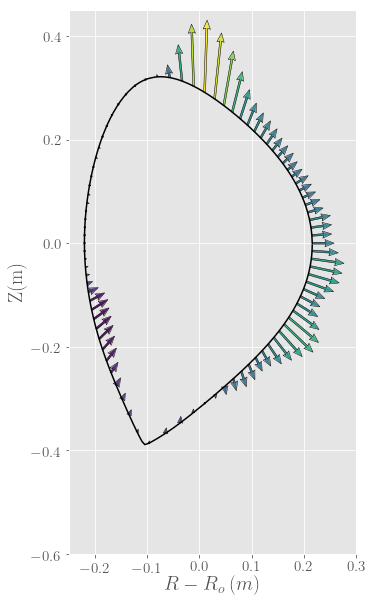

In [24]:
s_tur_i = P.smooth(gamma_turb_avg_i,10)
'''Turbulent ion ExB Flux.'''
new_an = np.arctan2(Z_s,R_s)
Turx,Tury = s_tur_i*np.cos(new_an), s_tur_i*np.sin(new_an)
plt.figure(figsize=(10,10))
plt.quiver(R_s[::4], Z_s[::4], Turx[::4], Tury[::4], s_tur_i[::4], alpha=.9)
plt.quiver(R_s[::4], Z_s[::4], Turx[::4], Tury[::4], edgecolor='k', facecolor='None', linewidth=.5, headwidth = 4)
plt.plot(R_s,Z_s,'k-')
plt.xlabel(r'$R-R_o \,(m)$')
plt.ylabel('Z(m)')
plt.xlim(-0.25,0.3)
plt.ylim(-0.6,0.45)
plt.axes().set_aspect(0.99)
plt.show()

C:\Users\giann\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


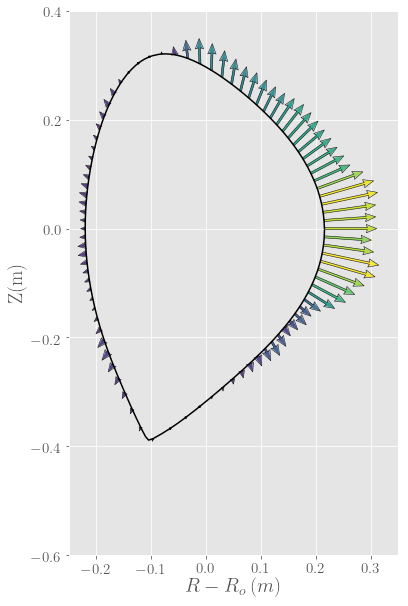

In [25]:
s_tur_e = P.smooth(gamma_turb_avg_e,10)
'''Turbulent electron ExB Flux.'''
new_an = np.arctan2(Z_s,R_s)
Turx,Tury = s_tur_e*np.cos(new_an), s_tur_e*np.sin(new_an)
plt.figure(figsize=(10,10))
plt.quiver(R_s[::4], Z_s[::4], Turx[::4], Tury[::4], s_tur_e[::4], alpha=.9)
plt.quiver(R_s[::4], Z_s[::4], Turx[::4], Tury[::4], edgecolor='k', facecolor='None', linewidth=.5, headwidth = 4)
plt.plot(R_s,Z_s,'k-')
plt.xlabel(r'$R-R_o \,(m)$')
plt.ylabel('Z(m)')
plt.xlim(-0.25,0.35)
plt.ylim(-0.6,0.4)
plt.axes().set_aspect(0.99)
plt.show()

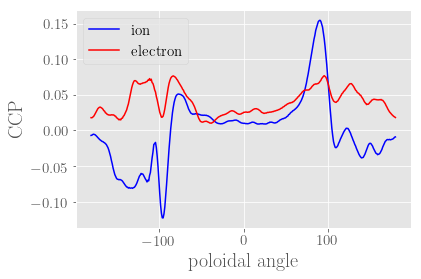

In [26]:
'''Cross Correlations'''
CCPi = gamma_turb_avg_i/(dPi_rms*dv_rms)
CCPe = gamma_turb_avg_e/(dPe_rms*dv_rms)
plt.plot([x for x in range(-180,180)], np.roll(P.smooth(CCPi[0:360],10),180),color='b',label='ion')
plt.plot([x for x in range(-180,180)], np.roll(P.smooth(CCPe[0:360],10),180),color='r',label='electron')
plt.xlabel("poloidal angle")
plt.ylabel(r"CCP")
plt.legend()
plt.show()

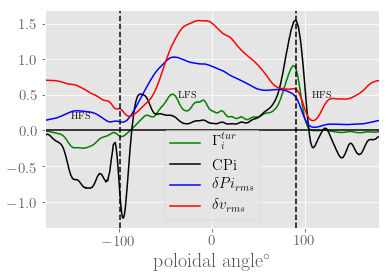

In [27]:
'''Turbulence Strenghts-ions'''
plt.plot([x for x in range(-180,180)], np.roll(P.smooth(gamma_turb_avg_i[0:360],10)/1.e24,180), color = 'g',label=r'$\Gamma^{tur}_i$')
plt.plot([x for x in range(-180,180)], np.roll(P.smooth(CCPi[0:360],10)*10,180), color = 'k',label='CPi')
plt.plot([x for x in range(-180,180)], np.roll(P.smooth(dPi_rms[0:360]/1.e22,10),180), color = 'b', label=r'$\delta Pi_{rms}$')
plt.plot([x for x in range(-180,180)], np.roll(P.smooth(dv_rms[0:360],10)/2.e3,180), color = 'r', label=r'$\delta v_{rms}$')
plt.axvline(x=-99,color='k',linestyle='--')
plt.axvline(x=90,color='k',linestyle='--')
plt.axhline(y=0,color='k',linestyle='-')
plt.annotate('LFS', xy=(0.3,0.5),xytext=(0.4, 0.6),textcoords='axes fraction')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.8, 0.6),textcoords='axes fraction')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.08, 0.5),textcoords='axes fraction')
plt.xlim(-180,180)
plt.xlabel(r"poloidal angle$^{\circ}$")
plt.legend()
plt.show()

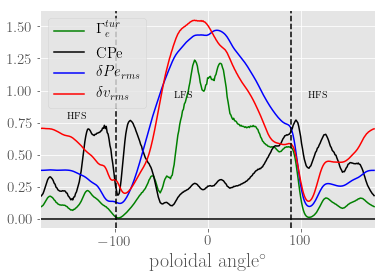

In [28]:
'''Turbulence Strenghts-electrons'''
plt.plot([x for x in range(-180,180)], np.roll(P.smooth(gamma_turb_avg_e[0:360],10)/1.e24,180), color = 'g',label=r'$\Gamma^{tur}_e$')
plt.plot([x for x in range(-180,180)], np.roll(P.smooth(CCPe[0:360],10)*10,180), color = 'k',label='CPe')
plt.plot([x for x in range(-180,180)], np.roll(P.smooth(dPe_rms[0:360]/1.e22,10),180), color = 'b', label=r'$\delta Pe_{rms}$')
plt.plot([x for x in range(-180,180)], np.roll(P.smooth(dv_rms[0:360],10)/2.e3,180), color = 'r', label=r'$\delta v_{rms}$')
plt.axvline(x=-99,color='k',linestyle='--')
plt.axvline(x=90,color='k',linestyle='--')
plt.axhline(y=0,color='k',linestyle='-')
plt.annotate('LFS', xy=(0.3,0.5),xytext=(0.4, 0.6),textcoords='axes fraction')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.8, 0.6),textcoords='axes fraction')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.08, 0.5),textcoords='axes fraction')
plt.xlim(-180,180)
plt.xlabel(r"poloidal angle$^{\circ}$")
plt.legend()
plt.show()

Comparison of two fluxes.

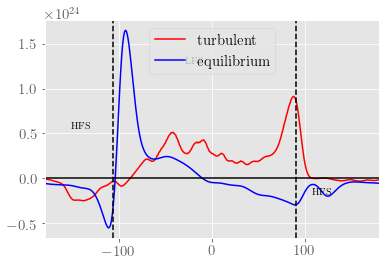

In [29]:
'''Comparison of ion fluxes.'''
plt.plot([x for x in range(-180,180)],np.roll(s_tur_i,180),'r-',label = 'turbulent')
plt.plot([x for x in range(-180,180)],np.roll(s_eq_gamma_i,180),'b-',label = 'equilibrium')
plt.axvline(x=-106,color='k',linestyle='--')
plt.axvline(x=90,color='k',linestyle='--')
plt.axhline(y=0,color='k',linestyle='-')
plt.annotate('LFS', xy=(0.3,0.5),xytext=(0.42, 0.8),textcoords='axes fraction')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.8, 0.2),textcoords='axes fraction')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.08, 0.5),textcoords='axes fraction')
plt.legend()
plt.xlim(-180,180)
plt.show()

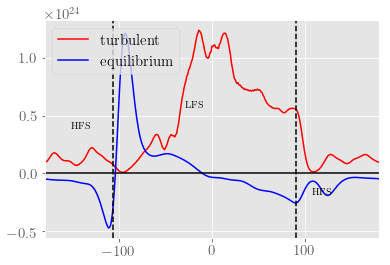

In [30]:
'''Comparison of electron fluxes.'''
plt.plot([x for x in range(-180,180)],np.roll(s_tur_e,180),'r-',label = 'turbulent')
plt.plot([x for x in range(-180,180)],np.roll(s_eq_gamma_e,180),'b-',label = 'equilibrium')
plt.axvline(x=-106,color='k',linestyle='--')
plt.axvline(x=90,color='k',linestyle='--')
plt.axhline(y=0,color='k',linestyle='-')
plt.annotate('LFS', xy=(0.3,0.5),xytext=(0.42, 0.6),textcoords='axes fraction')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.8, 0.2),textcoords='axes fraction')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.08, 0.5),textcoords='axes fraction')
plt.legend(loc=2)
plt.xlim(-180,180)
plt.show()

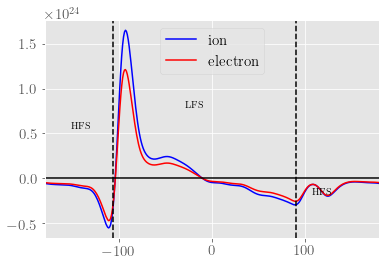

In [31]:
'''Comparison of equilibrium fluxes.'''
plt.plot([x for x in range(-180,180)],np.roll(s_eq_gamma_i,180),'b-',label = 'ion')
plt.plot([x for x in range(-180,180)],np.roll(s_eq_gamma_e,180),'r-',label = 'electron')
plt.axvline(x=-106,color='k',linestyle='--')
plt.axvline(x=90,color='k',linestyle='--')
plt.axhline(y=0,color='k',linestyle='-')
plt.annotate('LFS', xy=(0.3,0.5),xytext=(0.42, 0.6),textcoords='axes fraction')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.8, 0.2),textcoords='axes fraction')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.08, 0.5),textcoords='axes fraction')
plt.legend()
plt.xlim(-180,180)
plt.show()

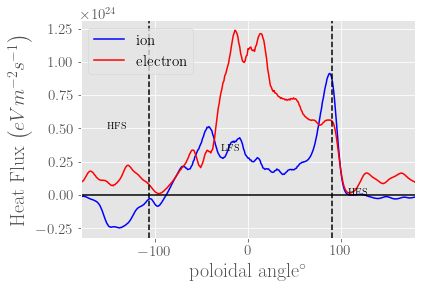

In [33]:
'''Comparison of turbulent fluxes.'''
plt.plot([x for x in range(-180,180)],np.roll(s_tur_i,180),'b-',label = 'ion')
plt.plot([x for x in range(-180,180)],np.roll(s_tur_e,180),'r-',label = 'electron')
plt.axvline(x=-106,color='k',linestyle='--')
plt.axvline(x=90,color='k',linestyle='--')
plt.axhline(y=0,color='k',linestyle='-')
plt.annotate('LFS', xy=(0.3,0.5),xytext=(0.42, 0.4),textcoords='axes fraction')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.8, 0.2),textcoords='axes fraction')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.08, 0.5),textcoords='axes fraction')
plt.xlabel(r'poloidal angle$^{\circ}$')
plt.ylabel(r'Heat Flux $\left(eV m^{-2} s^{-1}\right)$')
plt.legend()
plt.xlim(-180,180)
plt.show()

In [33]:
'''Writing fluxes on text files for easy retrieval.'''
file = open("ti262_tur_heat_exb_fluxes(fig.4.b).txt",'a')
file.write("Ang."+"\t"+"tur_i"+"\t"+"tur_e"+"\n")
for i in range(0,360):
    file.write(str(i)+"\t"+str(s_tur_i[i])+"\t"+str(s_tur_e[i])+"\n")
file.close()    

In [30]:
'''Writing fluxes on text files for easy retrieval.'''
#file = open("ti262_electron_heat_exb_fluxes.txt",'a')
#file.write("Ang."+"\t"+"Eq."+"\t"+"Tur."+"\n")
#for i in range(len(angle)):
#    file.write(str(angle[i])+"\t"+str(s_eq_gamma_e[i])+"\t"+str(s_tur_e[i])+"\n")
#file.close()    

'Writing fluxes on text files for easy retrieval.'

# Integrals

In [31]:
'''Radii.'''
r_s,R_maj_s = P.major_R(R_s,Z_s)

In [32]:
'''Heat current accross the separatrix.'''
Equilibrium_Heat_Curr_i = P.Tokamak_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],s_eq_gamma_i[0:360])
Turbulent_Heat_Curr_i = P.Tokamak_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],s_tur_i[0:360])
print("Equilibrium ion heat current = ",Equilibrium_Heat_Curr_i)
print("Turbulent ion heat current = ",Turbulent_Heat_Curr_i)
Equilibrium_Heat_Curr_e = P.Tokamak_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],s_eq_gamma_e[0:360])
Turbulent_Heat_Curr_e = P.Tokamak_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],s_tur_e[0:360])
print("Equilibrium electron heat current = ",Equilibrium_Heat_Curr_e)
print("Turbulent electron heat current = ",Turbulent_Heat_Curr_e)

Equilibrium ion heat current =  3.841139603438753e+23
Turbulent ion heat current =  1.1406016237849601e+24
Equilibrium electron heat current =  1.8096999034959642e+23
Turbulent electron heat current =  2.838087976050459e+24


In [33]:
'''FSA <Q grad\psi>'''
normalization = P.Normalization(Bp[0:360],r_s[0:360],angle[0:360])
Equilibrium_grad_FSA_i = P.Tokamak_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],s_eq_gamma_i[0:360])/normalization
Turbulent_grad_FSA_i = P.Tokamak_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],s_tur_i[0:360])/normalization
print("Equilibrium ion grad FSA = ",Equilibrium_grad_FSA_i)
print("Turbulent ion grad FSA = ",Turbulent_grad_FSA_i)
print("cancellation Equilibrium ion = ",Equilibrium_grad_FSA_i/max(s_eq_gamma_i))
print("cancellation Turbulent ion = ",Turbulent_grad_FSA_i/max(s_tur_i))
Equilibrium_grad_FSA_e = P.Tokamak_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],s_eq_gamma_e[0:360])/normalization
Turbulent_grad_FSA_e = P.Tokamak_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],s_tur_e[0:360])/normalization
print("Equilibrium electron grad FSA = ",Equilibrium_grad_FSA_e)
print("Turbulent electron grad FSA = ",Turbulent_grad_FSA_e)
print("cancellation Equilibrium electron = ",Equilibrium_grad_FSA_e/max(s_eq_gamma_e))
print("cancellation Turbulent electron = ",Turbulent_grad_FSA_e/max(s_tur_e))

Equilibrium ion grad FSA =  1.6711603235707867e+22
Turbulent ion grad FSA =  4.962402764438426e+22
cancellation Equilibrium ion =  0.010134490548020802
cancellation Turbulent ion =  0.054372468172296816
Equilibrium electron grad FSA =  7.873441188091303e+21
Turbulent electron grad FSA =  1.2347637706613934e+23
cancellation Equilibrium electron =  0.006502730365908926
cancellation Turbulent electron =  0.09979357344009332


In [34]:
'''FSA'''
normalization = P.Normalization(Bp[0:360],r_s[0:360],angle[0:360])
Equilibrium_FSA_i = P.FSA_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],s_eq_gamma_i[0:360])/normalization
Turbulent_FSA_i = P.FSA_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],s_tur_i[0:360])/normalization
print("Equilibrium ion FSA = ",Equilibrium_FSA_i)
print("Turbulent ion FSA = ",Turbulent_FSA_i)
print("cancellation Equilibrium ion = ",Equilibrium_FSA_i/max(s_eq_gamma_i))
print("cancellation Turbulent ion = ",Turbulent_FSA_i/max(s_tur_i))
Equilibrium_FSA_e = P.FSA_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],s_eq_gamma_e[0:360])/normalization
Turbulent_FSA_e = P.FSA_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],s_tur_e[0:360])/normalization
print("Equilibrium electron FSA = ",Equilibrium_FSA_e)
print("Turbulent electron FSA = ",Turbulent_FSA_e)
print("cancellation Equilibrium electron = ",Equilibrium_FSA_e/max(s_eq_gamma_e))
print("cancellation Turbulent electron = ",Turbulent_FSA_e/max(s_tur_e))

Equilibrium ion FSA =  1.0534311732881817e+22
Turbulent ion FSA =  6.11310301210364e+22
cancellation Equilibrium ion =  0.006388368678995465
cancellation Turbulent ion =  0.06698055654440445
Equilibrium electron FSA =  -4.509416279565811e+21
Turbulent electron FSA =  2.1463878899826173e+23
cancellation Equilibrium electron =  -0.0037243585711936116
cancellation Turbulent electron =  0.17347100928882508
